# 02 Computational Representations of (Biomedical) Shapes

## A) Shapes of Curves

$\color{#003660}{\text{Nina Miolane - Assistant Professor}}$ @ BioShape Lab @ UCSB ECE

<center><img src="figs/02_cells.png" width=800px alt="default"/></center>
<center>Cell images obtained by fluorescence microscopy. </center>


# Outline: Geometric Learning for BioShape Analysis

- **Unit 1 (Geometry - Math!)**: Differential Geometry for Engineers
- **Unit 2 (Shapes): Computational Representations of Biomedical Shapes**
- **Unit 3 (Machine Learning)**: Geometric Machine Learning for Shape Analysis
- **Unit 4 (Deep Learning)**: Geometric Deep Learning for Shape Analysis

<center><img src="figs/00_bioshape.jpg" width=500px alt="default"/></center>

Examples and applications will be taken from cutting-edge research in the **biomedical field**.

# Outline

- **Unit 2 (Shapes): Computational Representations of Biomedical Shapes**
  - A) Shapes of landmarks
  - B) Shapes of curves
  - C) Shapes of surfaces
  - D) Graphs
  - E) Deformations

# Outline

- **Unit 2 (Shapes): Computational Representations of Biomedical Shapes**
  - A) Shapes of landmarks
  - **B) Shapes of curves**
    - Motivation: Shape of Cancer Treatments
    - Practice: Analysis with SRV
    - Theory: Geometry of SRV manifolds
    - Application: Osteoscarcoma cells
  - C) Shapes of surfaces
  - D) Graphs
  - E) Deformations

## Motivation: Shape of Cancer Treatments

### Cell Shapes, aka Cell Morphologies

- Biological cells adopt a variety of shapes, via processes and biophysical forces under the control of the cell. 
- The emergence of large-scale biological cell image data raises interest for morphological studies, i.e. studies of cell shapes.

$\color{#047C91}{\text{Example}}$: Irregular cell shapes discriminates between cancer cells treated with different drugs.

<center><img src="figs/02_cells.png" width=700px alt="default"/></center>
<center>Cell images obtained by fluorescence microscopy, provided by A. Prasad, Colorado State University. </center>
<center> The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. </center>

### A Closer Look: Actin


$\color{#EF5645}{\text{Definition}}$: Actin is a family of globular multi-functional proteins that form microfilaments in the cytoskeleton. They participate in important cellular processes, including:
- muscle contraction, cell motility, cell division and cytokinesis, cell signaling, 
- and the establishment and maintenance of cell junctions and **cell shape**.

$\rightarrow$ "Actin" plays a crucial role in determining a cell shape. 

$\rightarrow$ Conversely, cell shapes can give us insights about the function of actin in the cell.

<center><img src="figs/02_actin.jpeg" width=300px alt="default"/></center>
<center>Human Lung Carcinoma Cells (A-549) - https://tinyurl.com/2p8axfxe</center>


### Question and Data

$\color{#EF5645}{\text{Question}}$: Which cancer treatments affect cells' actin and cytoskeleton?


$\color{#EF5645}{\text{Data}}$: Images of mouse osteosarcoma (bone cancer) cells from fluorescence microscopy
- 2 cell lines (i.e. cultures of cells): 
  - DUNN and DLM8 (more aggressive cancer)
- 3 states: 
  - 1 control group, 2 cancer treatments: Jasplakinolide (jasp) and cytochalasin D (cytd).

$\rightarrow$ On each image, segment the cell boundary (ECE 278a) to form a discrete closed curve.


<center><img src="figs/02_binarized_cells.png" width=400px alt="default"/></center>
<center>Segmented cell images from which the boundary can be extracted.</center>



### Load the Dataset

In [117]:
import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")
print(f"The array contained the 0th cell has shape {cells[0].shape}.")

Total number of cells : 650
The array contained the 0th cell has shape (210, 2).


In [119]:
import numpy as np
import pandas as pd

TREATMENTS = np.unique(treatments); print(TREATMENTS)
LINES = np.unique(lines); print(LINES)

['control' 'cytd' 'jasp']
['dlm8' 'dunn']


In [120]:
ds = {}; n_cells_arr = np.zeros((3, 2))
for i, treatment in enumerate(TREATMENTS):
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = np.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]}); n_cells_df = n_cells_df.set_index(TREATMENTS)
display(n_cells_df)

,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


### Difference: Landmarks and Curves

Landmarks are "biologically meaningful" points: 
  - Their index is biologically relevant.

Curves are made of sampling points that are discretizing a continuous curve: 
  - Their position along the curve is not biologically relevant.

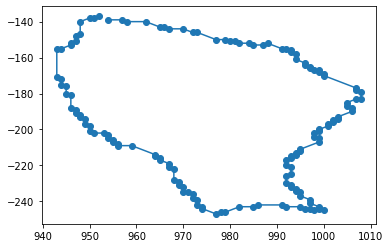

In [27]:
import matplotlib.pyplot as plt
plt.plot(cells[1][:, 0], cells[1][:, 1], "C0", marker="o");

### From Curves to Shapes of Curves

$\color{#EF5645}{\text{Definition}}$: Two curves are said to have the same shape if one set can be obtained by translating, rotating, re-scaling, or reparameterizing the other.

$\rightarrow$ We do not want to do machine learning on the curves directly...

...but rather on the shapes of these curves.

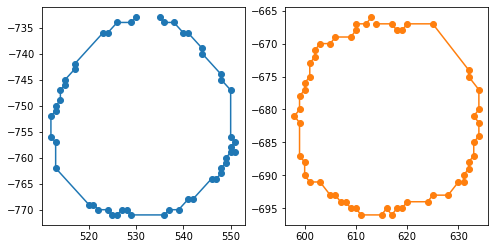

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(cells[2][:, 0], cells[2][:, 1], "C0", marker="o"); axes[1].plot(cells[3][:, 0], cells[3][:, 1], "C1", marker="o");

## Practice: Analysis in Quotient SRV space

1. Perform an equivalent of Procrustes Analysis:
- Remove translation, scaling, and rotation:
  - as in Procrustes analysis, by optimally superimposing the curves.
  - (In what follows, we will make sure that this has already been done).
- Remove reparameterization:
  - by computing in a "Quotient SRV" space.
  
2. Perform statistical analysis of superimposed objects in Quotient SRV space.

<center><img src="figs/02_procrustes.png" width=900px alt="default"/></center>


### Make toy dataset of 2 curves.

Create two parameterized curves in the 2D Euclidean plane $\mathbb{R}^2$.

In [122]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves

r2 = Euclidean(dim=2)
curves_r2 = DiscreteCurves(ambient_manifold=r2)

parametrized_curve_a = lambda x: np.transpose(
    np.array([1 + 2 * np.sin(np.pi * x), 3 + 2 * np.cos(np.pi * x)]) / (2*np.pi)
)
parametrized_curve_b = lambda x: np.transpose(
    np.array([5 * np.ones(len(x)), 4 * (1 - x) + 1]) / 4
)

Sample points along these curves to turn them into discrete curves.
- We have made sure that the curves have same length and are centered already.

In [123]:
import numpy as np
import matplotlib.pyplot as plt

n_sampling_points = 40
sampling_points = np.linspace(0.0, 1.0, n_sampling_points + 1)
curve_a = parametrized_curve_a(sampling_points); curve_a -= np.mean(curve_a, axis=0)
curve_b = parametrized_curve_b(sampling_points); curve_b -= np.mean(curve_b, axis=0)
print(curve_a.shape, curve_b.shape)

len_a = sum([np.linalg.norm(curve_a[i] - curve_a[i-1]) for i in range(1, n_sampling_points)])
len_b = sum([np.linalg.norm(curve_b[i] - curve_b[i-1]) for i in range(1, n_sampling_points)])

print("Lengths of the two curves:", len_a, len_b)

(41, 2) (41, 2)
Lengths of the two curves: 0.9747494238975263 0.9750000000000001


Visualize the curves.

- We have made sure that the curves are optimally oriented already.

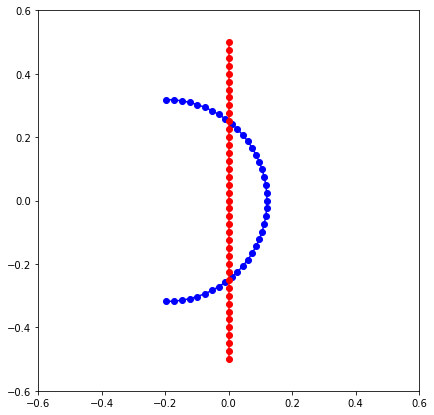

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(curve_a[:, 0], curve_a[:, 1], "o-b")
ax.plot(curve_b[:, 0], curve_b[:, 1], "o-r")
ax.set_aspect('equal'); ax.set_ylim((-0.6, 0.6)); ax.set_xlim((-0.6, 0.6));

Get our main tool: the `metric` of the Quotient SRV space.

$\rightarrow$ computes between curve shapes, independently of their parameterization.

In [125]:
metric = curves_r2.quotient_square_root_velocity_metric

dist_ab = metric.dist(curve_a, curve_b)
print(f"The distance between the two curves shapes is: {dist_ab}")

The distance between the two curves shapes is: 0.7382956522859976


Visualize the geodesic.

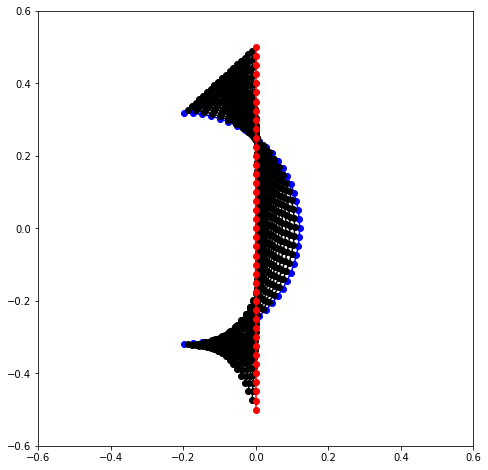

In [127]:
geod_fun = metric.geodesic(initial_curve=curve_a, end_curve=curve_b)
n_times = 20; times = np.linspace(0.0, 1.0, n_times); geod = geod_fun(times)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(geod[0, :, 0], geod[0, :, 1], "o-b")
for i in range(1, n_times - 1):
    ax.plot(geod[i, :, 0], geod[i, :, 1], "o-k")
ax.plot(geod[-1, :, 0], geod[-1, :, 1], "o-r"); ax.set_aspect('equal'); ax.set_ylim((-0.6, 0.6)); ax.set_xlim((-0.6, 0.6));

Change visualization to better observe the same geodesic.

(-0.3, 1.2)

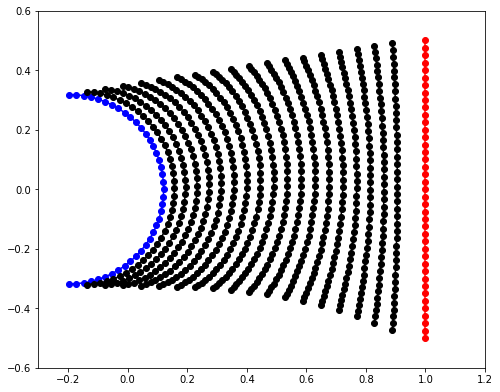

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(geod[0, :, 0], geod[0, :, 1], "o-b")
for i in range(1, n_times - 1):
    ax.plot(geod[i, :, 0]+i/n_times, geod[i, :, 1], "o-k")
ax.plot(geod[-1, :, 0]+1, geod[-1, :, 1], "o-r")
ax.set_aspect('equal'); ax.set_ylim((-0.6, 0.6)); ax.set_xlim((-0.3, 1.2));

Effect of reparameterization?

In [131]:
reparam_curve_a = parametrized_curve_a(sampling_points ** 2)
reparam_curve_a -= np.mean(reparam_curve_a, axis=0)
reparam_curve_b = parametrized_curve_b(sampling_points ** 2)
reparam_curve_b -= np.mean(reparam_curve_b, axis=0)

Visualize reparameterized curves.

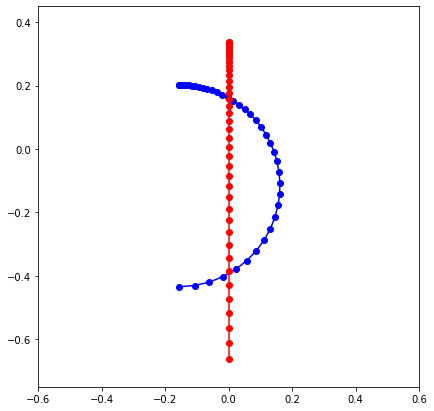

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(reparam_curve_a[:, 0], reparam_curve_a[:, 1], "o-b")
ax.plot(reparam_curve_b[:, 0], reparam_curve_b[:, 1], "o-r")
ax.set_aspect('equal'); ax.set_ylim((-0.75, 0.45)); ax.set_xlim((-0.6, 0.6));

Check that the distance between shapes does not change.

In [140]:
dist_ab = metric.dist(curve_a, curve_b)
print(f"The distance between the two curves shapes is: {dist_ab:.3f}")

dist_ab = metric.dist(reparam_curve_a, curve_b)
print(f"The distance between the two curves shapes is: {dist_ab:.3f}")

dist_ab = metric.dist(curve_a, reparam_curve_b)
print(f"The distance between the two curves shapes is: {dist_ab:.3f}")

dist_ab = metric.dist(reparam_curve_a, reparam_curve_b)
print(f"The distance between the two curves shapes is: {dist_ab:.3f}")

The distance between the two curves shapes is: 0.738
The distance between the two curves shapes is: 0.738
The distance between the two curves shapes is: 0.738
The distance between the two curves shapes is: 0.738


Compute new geodesic between a reparameterized curve and an original curve.

In [141]:
geod_fun = metric.geodesic(
    initial_curve=curve_a, end_curve=reparam_curve_b
)

n_times = 20
times = np.linspace(0.0, 1.0, n_times)
geod = geod_fun(times)

(-0.3, 1.2)

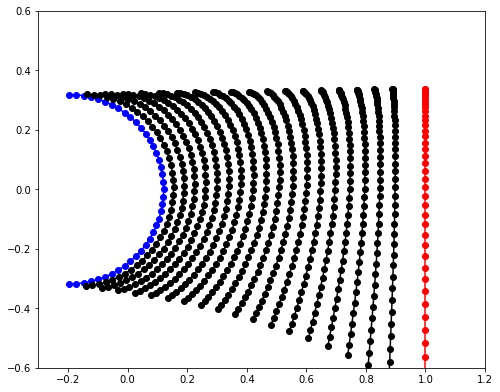

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(geod[0, :, 0], geod[0, :, 1], "o-b")
for i in range(1, n_times - 1):
    ax.plot(geod[i, :, 0]+i/n_times, geod[i, :, 1], "o-k")
ax.plot(geod[-1, :, 0]+1, geod[-1, :, 1], "o-r"); ax.set_aspect('equal'); ax.set_ylim((-0.6, 0.6)); ax.set_xlim((-0.3, 1.2))

## Theory: SRV Manifolds

## Application: Understanding Cancer Treatments

# Outline

- **Unit 2 (Shapes): Computational Representations of Biomedical Shapes**
  - **A) Shapes of landmarks**
    - Motivation: Shape of Glaucoma
    - Practice: Procrustes Analysis
    - Theory: Kendall Shape Spaces
    - Application: Innovation in Pelvis Surgery
  - B) Shapes of curves
  - C) Shapes of surfaces
  - D) Graphs
  - E) Deformations
  
Questions?